In [1]:
import os
import sys
import importlib
from pathlib import Path

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [2]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# models dir
models_save_path = f'{data_dir}classification models/'

# output tables dir
table_save_path = f'{data_dir}output tables/'

# plots dir
plot_save_path = f'{data_dir}plots/'

In [3]:
import string
import re
import time
import timeit
import tqdm
import json
import csv
import glob
import pickle
import joblib
import random
import itertools
import unicodedata
import contextlib
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns


In [4]:
# ML imports
import sklearn
from sklearn import feature_selection, metrics, set_config, svm, utils
from sklearn.utils import (check_consistent_length, check_random_state, check_X_y, parallel_backend)
from sklearn.utils.validation import (check_is_fitted, column_or_1d,
                                      has_fit_parameter)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.feature_selection import (SelectFdr, SelectFpr,
                                       SelectFromModel, SelectFwe,
                                       SelectKBest, SelectPercentile, chi2,
                                       f_classif, f_regression,
                                       mutual_info_classif,
                                       mutual_info_regression)
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import (LogisticRegression,
                                  PassiveAggressiveClassifier, Perceptron,
                                  SGDClassifier)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              BaggingRegressor, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, StackingClassifier,
                              StackingRegressor, VotingClassifier,
                              VotingRegressor)
from sklearn.model_selection import (GridSearchCV, KFold, LeaveOneOut,
                                     RandomizedSearchCV,
                                     RepeatedStratifiedKFold, ShuffleSplit,
                                     StratifiedKFold,
                                     StratifiedShuffleSplit,
                                     cross_val_score, cross_val_predict, cross_validate,
                                     learning_curve, train_test_split)
from sklearn.metrics import (ConfusionMatrixDisplay,accuracy_score, balanced_accuracy_score,
                             brier_score_loss, classification_report, cohen_kappa_score,
                             confusion_matrix, f1_score, log_loss,
                             make_scorer, matthews_corrcoef, fowlkes_mallows_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score)
from sklearn.calibration import CalibrationDisplay
import imblearn
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.under_sampling import (EditedNearestNeighbours, NearMiss,
                                     RandomUnderSampler, TomekLinks)
from xgboost import XGBClassifier
import plot_metric
from plot_metric.functions import BinaryClassification
import torch


### READ DATA

In [5]:
# Variables
plt.style.use('tableau-colorblind10')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 5000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:.3f}'.format)
random_state = 42
random.seed(random_state)
np.random.seed(random_state)

method = 'Supervised'
n_jobs = -1
cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=3, random_state=random_state)
t = time.time()
cores = multiprocessing.cpu_count()
scoring = 'recall'
scores = ['recall', 'accuracy', 'f1', 'roc_auc', 'explained_variance', 'matthews_corrcoef']
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
}
analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'

metrics_dict = {
    'Mean Validation Score': np.nan,
    'Explained Variance': np.nan,
    'Accuracy': np.nan,
    'Balanced Accuracy': np.nan,
    'Precision': np.nan,
    'Recall': np.nan,
    'F1-score': np.nan,
    'Matthews Correlation Coefficient': np.nan,
    'Fowlkes–Mallows Index': np.nan,
    'ROC': np.nan,
    'AUC': np.nan,
    f'{scoring.title()} Best Threshold': np.nan,
    f'{scoring.title()}  Best Score': np.nan,
    'Log Loss/Cross Entropy': np.nan,
    'Cohen’s Kappa': np.nan,
    'Geometric Mean': np.nan,
    'Classification Report': np.nan,
    'Confusion Matrix': np.nan,
    'Normalized Confusion Matrix': np.nan
}

## Vectorizers

In [6]:
### CountVectorizer
count_ = CountVectorizer()
count_params = {
#     'TfidfVectorizer__stop_words': ['english'],
    'CountVectorizer__analyzer': ['word'],
    'CountVectorizer__ngram_range': [(1, 3)],
    'CountVectorizer__lowercase': [True, False],
    'CountVectorizer__max_df': [0.90, 0.85, 0.80, 0.75, 0.70],
    'CountVectorizer__min_df': [0.10, 0.15, 0.20, 0.25, 0.30],
}
count = [count_, count_params]

### TfidfVectorizer
tfidf_ = TfidfVectorizer()
tfidf_params = {
#     'TfidfVectorizer__stop_words': ['english'],
    'TfidfVectorizer__analyzer': ['word'],
    'TfidfVectorizer__ngram_range': [(1, 3)],
    'TfidfVectorizer__lowercase': [True, False],
    'TfidfVectorizer___use_idf': [True, False],
    'TfidfVectorizer__max_df': [0.90, 0.85, 0.80, 0.75, 0.70],
    'TfidfVectorizer__min_df': [0.10, 0.15, 0.20, 0.25, 0.30],
}
tfidf = [tfidf_, tfidf_params]

## Vectorizers List
vectorizers_list = [
    count, 
    tfidf
]

### BOW FeatureUnion
transformer_list = []
bow_params = {}
for vectorizer_and_params in vectorizers_list:
    transformer_list.append(
        (vectorizer_and_params[0].__class__.__name__, vectorizer_and_params[0])
    )
    for k, v in vectorizer_and_params[1].items():
        bow_params[f'FeatureUnion__{k}'] = v

bow_ = FeatureUnion(
    transformer_list=[transformer_list]
)
bow = [bow_, bow_params]

## Vectorizers List append bow
vectorizers_list.append(bow)

## Vectorizers Dict
vectorizers_pipe = {
    vectorizer_and_params[0].__class__.__name__: vectorizer_and_params
    for vectorizer_and_params in vectorizers_list
}



## Selectors

In [7]:
### SelectKBest
selectkbest_ = SelectKBest()
selectkbest_params = {
    'SelectKBest__score_func': [f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression],
    'SelectKBest__k': ['all'],
}
selectkbest = [selectkbest_, selectkbest_params]

### SelectPercentile
selectperc_ = SelectPercentile()
selectperc_params = {
    'SelectPercentile__score_func': [f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression],
    'SelectPercentile__percentile': [30, 40, 50, 60, 70, 80],
}
selectperc = [selectperc_, selectperc_params]

### SelectFpr
selectfpr_ = SelectFpr()
selectfpr_params = {
    'SelectFpr__score_func': [f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression],
}
selectfpr = [selectfpr_, selectfpr_params]

### SelectFdr
selectfdr_ = SelectFdr()
selectfdr_params = {
    'SelectFdr__score_func': [f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression],
}
selectfdr = [selectfdr_, selectfdr_params]

### SelectFwe
selectfwe_ = SelectFwe()
selectfwe_params = {
    'SelectFwe__score_func': [f_classif, chi2, mutual_info_classif, f_regression, mutual_info_regression],
}
selectfwe = [selectfwe_, selectfwe_params]

## Selectors List
selectors_list = [
    selectkbest, selectperc,
    # selectfpr, selectfdr, selectfwe
]
## Selectors Dict
selectors_pipe = {
    selector_and_params[0].__class__.__name__: selector_and_params
    for selector_and_params in selectors_list
}


## Resamplers

In [8]:
# Resamplers
### SMOTETomek Resampler
smotetomek_ = SMOTETomek()
smotetomek_params = {
    'SMOTETomek__random_state': [random_state],
    'SMOTETomek__tomek': [TomekLinks(sampling_strategy='majority')],
}
smotetomek = [smotetomek_, smotetomek_params]

## Resampler List
resamplers_list = [
    smotetomek,
]

## Resampler Dict
resamplers_pipe = {
    resampler_and_params[0].__class__.__name__: resampler_and_params
    for resampler_and_params in resamplers_list
}

## Classifiers

In [9]:
# Classifiers
### Dummy Classifier
dummy_ = DummyClassifier()
dummy_params = {
    'DummyClassifier__strategy': [
        'stratified',
        'most_frequent',
        'prior',
        'uniform',
    ],
    'DummyClassifier__random_state': [random_state],
}

dummy = [dummy_, dummy_params]

### Multinomial Naive Bayes
nb_ = MultinomialNB()
nb_params = {
    'MultinomialNB__fit_prior': [True, False],
    # 'MultinomialNB__alpha': [0.1, 0.2, 0.3],
}

nb = [nb_, nb_params]

### Bernoulli Naive Bayes
bnb_ = BernoulliNB()
bnb_params = {
    'BernoulliNB__fit_prior': [True],
    'BernoulliNB__alpha': [0.1, 0.2, 0.3],
}

bnb = [bnb_, bnb_params]

### Gaussian Naive Bayes
gnb_ = GaussianNB()
gnb_params = {
    'GaussianNB__var_smoothing': [1e-9],
}

gnb = [gnb_, gnb_params]

### KNeighbors Classifier
knn_ = KNeighborsClassifier()
knn_params = {
    'KNeighborsClassifier__weights': ['uniform', 'distance'],
    'KNeighborsClassifier__n_neighbors': [2, 5, 15],
    'KNeighborsClassifier__algorithm': ['auto'],
    # 'KNeighborsClassifier__leaf_size': [30, 50, 100, 200, 300, 500],
    'KNeighborsClassifier__p': [1, 2, 3, 4, 5],
    # 'KNeighborsClassifier__metric': [
    #     'minkowski',
    #     'euclidean',
    #     'cosine',
    #     'correlation',
    # ],
    # 'KNeighborsClassifier__metric_params': [None, {'p': 2}, {'p': 3}],
}

knn = [knn_, knn_params]

### Logistic Regression
lr_ = LogisticRegression()
lr_params = {
    'LogisticRegression__penalty': ['elasticnet'],
    'LogisticRegression__class_weight': ['balanced'],
    'LogisticRegression__random_state': [random_state],
    'LogisticRegression__algorithm': ['auto'],
    'LogisticRegression__fit_intercept': [True, False],
    'LogisticRegression__multi_class': ['auto'],
    'LogisticRegression__solver': ['liblinear'],
    'LogisticRegression__C': [0.01, 1, 100],
    # 'LogisticRegression__max_iter': [100, 200, 300, 500, 1000],
}

lr = [lr_, lr_params]

### Passive Aggressive
pa_ = PassiveAggressiveClassifier()
pa_params = {
    'PassiveAggressiveClassifier__loss': ['hinge', 'squared_hinge'],
    'PassiveAggressiveClassifier__random_state': [random_state],
    'PassiveAggressiveClassifier__fit_intercept': [True, False],
    'PassiveAggressiveClassifier__class_weight': ['balanced'],
    'PassiveAggressiveClassifier__shuffle': [True, False],
    'PassiveAggressiveClassifier__C': [0.01, 1, 100],
    # 'PassiveAggressiveClassifier__max_iter': [100, 200, 300, 500, 1000],
}

pa = [pa_, pa_params]

### Perceptron
ptron_ = Perceptron()
ptron_params = {
    'Perceptron__penalty': ['elasticnet'],
    'Perceptron__random_state': [random_state],
    'Perceptron__fit_intercept': [True, False],
    'Perceptron__class_weight': ['balanced'],
    'Perceptron__shuffle': [True, False],
    'Perceptron__C': [0.01, 1, 100],
    # 'Perceptron__max_iter': [100, 200, 300, 500, 1000],
}

ptron = [ptron_, ptron_params]

### Stochastic Gradient Descent Aggressive
sgd_ = SGDClassifier()
sgd_params = {
    'SGDClassifier__loss': ['hinge', 'squared_hinge'],
    'SGDClassifier__random_state': [random_state],
    'SGDClassifier__fit_intercept': [True, False],
    'SGDClassifier__class_weight': ['balanced'],
    # 'SGDClassifier__max_iter': [100, 200, 300, 500, 1000],
}

sgd = [sgd_, sgd_params]

### SVM
svm_ = LinearSVC()
svm_params = {
    'LinearSVC__penalty': ['elasticnet'],
    'LinearSVC__loss': ['hinge', 'squared_hinge'],
    'LinearSVC__random_state': [random_state],
    'LinearSVC__fit_intercept': [True, False],
    'LinearSVC__class_weight': ['balanced'],
    # 'LinearSVC__multi_class': ['ovr', 'crammer_singer'],
    # 'LinearSVC__max_iter': [100, 200, 300, 500, 1000],
}

svm = [svm_, svm_params]

### Decision Tree
dt_ = DecisionTreeClassifier()
dt_params = {
    # 'DecisionTreeClassifier__max_depth': [5, 10],
    'DecisionTreeClassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'DecisionTreeClassifier__random_state': [random_state],
    'DecisionTreeClassifier__splitter': ['best', 'random'],
    'DecisionTreeClassifier__max_features': ['auto'],
    'DecisionTreeClassifier__class_weight': ['balanced'],
}

dt = [dt_, dt_params]

### Random Forest
rf_ = RandomForestClassifier()
rf_params = {
    'RandomForestClassifier__n_estimators': [10, 20],
    'RandomForestClassifier__max_feature': [*np.arange(0.1, 1.1, 0.1)],
    'RandomForestClassifier__random_state': [random_state],
    'RandomForestClassifier__class_weight': ['balanced'],
    'RandomForestClassifier__oob_score': [True],
}

rf = [rf_, rf_params]

### Extra Trees
et_ = ExtraTreesClassifier()
et_params = {
    'ExtraTreesClassifier__max_feature': ['sqrt'],
    'ExtraTreesClassifier__random_state': [random_state],
    'ExtraTreesClassifier__criterion': ['gini', 'entropy', 'log_loss'],
    'ExtraTreesClassifier__class_weight': ['balanced'],
}

et = [et_, et_params]

### Gradient Boosting
gbc_ = GradientBoostingClassifier()
gbc_params = {
    'GradientBoostingClassifier__random_state': [random_state],
    'GradientBoostingClassifier__loss': ['log_loss', 'deviance', 'exponential'],
    'GradientBoostingClassifier__max_features': ['auto'],
}

gbc = [gbc_, gbc_params]

### AdaBoost
ada_ = AdaBoostClassifier()
ada_params = {
    'AdaBoostClassifier__criterion': ['gini', 'entropy'],
    'AdaBoostClassifier__random_state': [random_state],
    'AdaBoostClassifier__n_estimators': [50, 100, 150],
    'AdaBoostClassifier__base_estimator': [
        SVC(kernel='linear'),
        LogisticRegression(),
        MultinomialNB(),
        DecisionTreeClassifier(),
    ],
}

ada = [ada_, ada_params]

### XGBoost
xgb_ = XGBClassifier()
xgb_params = {
    'XGBClassifier__seed': [random_state],
    'XGBClassifier__eval_metric': ['logloss'],
    'XGBClassifier__objective': ['binary:logistic'],
}

xgb = [xgb_, xgb_params]

### MLP Classifier
mlpc_ = MLPClassifier()
mlpc_params = {
    'MLPClassifier__hidden_layer_sizes': [(100,), (50,), (25,), (10,), (5,), (1,)],
    'MLPClassifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'MLPClassifier__solver': ['lbfgs', 'sgd', 'adam'],
    'MLPClassifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'MLPClassifier__random_state': [random_state],
}

mlpc = [mlpc_, mlpc_params]

### MLP Regressor
mlpr_ = MLPRegressor()
mlpr_params = {
    'MLPRegressor__hidden_layer_sizes': [(100,), (50,), (25,), (10,), (5,), (1,)],
    'MLPRegressor__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'MLPRegressor__solver': ['lbfgs', 'sgd', 'adam'],
    'MLPRegressor__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'MLPRegressor__random_state': [random_state],
}

mlpr = [mlpr_, mlpr_params]

## Classifiers List
classifers_list = [
    dummy, nb, knn, lr, pa, ptron, svm, dt, rf, ada, xgb, mlpc, 
    # bnb, gnb, sgd, et, gbc, mlpr
]

## Classifiers Dict
classifiers_pipe = {
    classifier_and_params[0].__class__.__name__: classifier_and_params
    for classifier_and_params in classifers_list
}

## Voting and Stacking Classifiers
# Estimators for Voting and Stacking Classifiers
voting_stacking_estimators = [
    (classifier_and_params[0].__class__.__name__, classifier_and_params[0])
    for classifier_and_params in classifers_list
]

### Voting Classifier
voting_ = VotingClassifier(estimators = voting_stacking_estimators)
voting_params = {
    'VotingClassifier__voting': ['soft', 'hard'],
    'VotingClassifier__weights': [None],
}

voting = [voting_, voting_params]

### Stacking Classifier
stacking_ = StackingClassifier(estimators = voting_stacking_estimators)
stacking_params = {
    'StackingClassifier__stack_method': ['auto', 'predict_proba', 'decision_function', 'predict'],
    'StackingClassifier__passthrough': [True, False],
}

stacking = [stacking_, stacking_params]

# Add stacking and voting classifiers to classifiers pipe dict
classifiers_pipe[voting[0].__class__.__name__] = voting
classifiers_pipe[stacking[0].__class__.__name__] = stacking


In [10]:
def split_data(df, col, analysis_columns, text_col=None):

    if text_col is None:
        text_col = 'Job Description spacy_sentencized'

    train_ratio = 0.75
    test_ratio = 0.10
    validation_ratio = 0.15
    test_split = test_size = 1 - train_ratio
    validation_split = test_ratio / (test_ratio + validation_ratio)

    # Split
    print('='*20)
    print('Splitting data into training, testing, and validation sets:')
    print(f'Ratios: train_size = {train_ratio}, test size = {test_ratio}, validation size = {validation_ratio}')

    df.dropna(subset=analysis_columns, how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)

    train, test = train_test_split(
        df, train_size = 1-test_split, test_size = test_split, random_state=random_state
    )

    val, test = train_test_split(
        test, test_size=validation_split, random_state=random_state
    )

    X_train = np.array(list(train[text_col].astype('str').values))
    y_train = column_or_1d(train[col].astype('int64').values.tolist(), warn=True)

    X_test = np.array(list(test[text_col].astype('str').values))
    y_test = column_or_1d(test[col].astype('int64').values.tolist(), warn=True)

    X_val = np.array(list(val[text_col].astype('str').values))
    y_val = column_or_1d(val[col].astype('int64').values.tolist(), warn=True)

    class_weights = compute_class_weight(class_weight = 'balanced', classes = [0,1], y = y_train)
    class_weights_ratio = class_weights[0]/class_weights[1]
    class_weights_dict = dict(zip(np.unique(y_train), class_weights))

    print('Done splitting data into training, testing, and validation sets.')
    print('='*20)
    print(f'Training set shape: {y_train.shape}')
    print('-'*10)
    print(f'Training set example:\n{X_train[0]}')
    print('~'*10)
    print(f'Testing set shape: {y_test.shape}')
    print('-'*10)
    print(f'Testing set example:\n{X_test[0]}')
    print('~'*10)
    print(f'Validation set shape: {y_val.shape}')
    print('-'*10)
    print(f'Validation set example:\n{X_val[0]}')
    print('~'*10)
    print(f'Class weights:\nRatio = {class_weights_ratio:.2f} (0 = {class_weights[0]:.2f}, 1 = {class_weights[1]:.2f})')
    print('='*20)

    return (
        train, X_train, y_train,
        test, X_test, y_test,
        val, X_val, y_val,
        class_weights,
        class_weights_ratio,
        class_weights_dict
    )


In [11]:
def make_df_metrics(vectorizers_pipe, classifiers_pipe, analysis_columns, metrics_list):

    index = pd.MultiIndex.from_product(
        [list(map(lambda classifier: classifier, classifiers_pipe.keys()))],
        names=['Classifiers'],
    )
    columns = pd.MultiIndex.from_product(
        [
            analysis_columns,
            list(map(lambda vectorizer: vectorizer, vectorizers_pipe.keys())),
            metrics_list,
        ],
        names=['Variable', 'Vectorizer', 'Measures'],
    )
    return pd.DataFrame(index=index, columns=columns)


In [12]:
def plot_metrics(cm_curve, cm_normalized_curve, roc_curve, pr_curve, calibration_curve, col, vectorizer_name, classifier_name):

    # Plots
    print('=' * 20)
    plt.clf()
    plt.cla()
    plt.close()
    print('Plotting:')

    ## Confusion Matrix
    print('-' * 20)
    print('Confusion Matrix:')
    fig, ax = plt.subplots()
    ax.set_title(f'Confusion Matrix {str(col)} - {vectorizer_name} + {classifier_name}')
    cm_curve.plot(ax=ax)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## Normalized Confusion Matrix
    print('-' * 20)
    print('Normalized Confusion Matrix:')
    fig, ax = plt.subplots()
    ax.set_title(f'Normalized Confusion Matrix {str(col)} - {vectorizer_name} + {classifier_name}')
    cm_normalized_curve.plot(ax=ax)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## ROC Curve
    print('-' * 20)
    print('ROC Curve:')
    fig, ax = plt.subplots()
    ax.set_title(f'ROC Curve {str(col)} - {vectorizer_name} + {classifier_name}')
    roc_curve.plot(ax=ax)
    ax.plot([0, 1], [0, 1],'r--', lw=1)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## PR Curve
    print('-' * 20)
    print('Precision Recall Curve:')
    fig, ax = plt.subplots()
    ax.set_title(f'Precision-Recall Curve {str(col)} - {vectorizer_name} + {classifier_name}')
    pr_curve.plot(ax=ax)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## Calibration Curve
    print('-' * 20)
    print('Calibration Curve:')
    fig, ax = plt.subplots()
    ax.set_title(f'Calibration Curve {str(col)} - {vectorizer_name} + {classifier_name}')
    calibration_curve.plot(ax=ax)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    print('=' * 20)

    # Save Plots
    print('Saving plots...')
    for image_save_format in ['eps', 'png']:
        cm_curve.figure_.savefig(
            f'{plot_save_path}{method} Confusion Matrix {str(col)} - {vectorizer_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        cm_normalized_curve.figure_.savefig(
            f'{plot_save_path}{method} Normalized Confusion Matrix {str(col)} - {vectorizer_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        roc_curve.figure_.savefig(
            f'{plot_save_path}{method} ROC Curve {str(col)} - {vectorizer_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        pr_curve.figure_.savefig(
            f'{plot_save_path}{method} Precision Recall Curve {str(col)} - {vectorizer_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        calibration_curve.figure_.savefig(
            f'{plot_save_path}{method} Calibration Curve {str(col)} - {vectorizer_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )



In [13]:
def compute_metrics(estimator, X_test, y_test, y_test_pred, y_test_pred_prob):

    # Get metrics
    # Using estimator
    cross_validate_score_noscoring = cross_validate(
        estimator,
        X_test,
        y_test,
        cv=cv,
        return_train_score=True,
    )
    cross_validate_score = cross_validate(
        estimator,
        X_test,
        y_test,
        cv=cv,
        return_train_score=True,
        scoring=scores,
    )
    mean_validation_score = cross_validate_score_noscoring.get('test_score').mean()
    )explained_variance = cross_validate_score.get('test_explained_variance').mean()

    # Using y_pred
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_test_pred)
    precision = metrics.precision_score(y_test, y_test_pred, pos_label=1, labels=[1, 0])
    recall = metrics.recall_score(y_test, y_test_pred, pos_label=1, labels=[1, 0])
    f1 = metrics.f1_score(y_test, y_test_pred)
    mcc = metrics.matthews_corrcoef(y_test, y_test_pred)
    fm = metrics.fowlkes_mallows_score(y_test, y_test_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_test_pred)
    gmean_iba = imblearn.metrics.make_index_balanced_accuracy(alpha=0.1, squared=True)(geometric_mean_score)
    gmean = gmean_iba(y_test, y_test_pred)
    report = metrics.classification_report(y_test, y_test_pred)
    cm = metrics.confusion_matrix(y_test, y_test_pred)
    cm_normalized = metrics.confusion_matrix(y_test, y_test_pred, normalize='true')

    # Using y_pred_prob
    loss = metrics.log_loss(y_test, y_test_pred_prob)
    roc_auc = metrics.roc_auc_score(y_test, y_test_pred_prob)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_test_pred_prob, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    precision_pr, recall_pr, threshold_pr = metrics.precision_recall_curve(y_test, y_test_pred_prob, pos_label=1)

    # Displays
    cm_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_test, y_test_pred
    )
    cm_normalized_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_test, y_test_pred, normalize='true'
    )
    roc_curve = metrics.RocCurveDisplay.from_predictions(
        y_test, y_test_pred, pos_label=1, name=f'{str(col)} - {vectorizer_name} + {classifier_name}'
    )
    pr_curve = metrics.PrecisionRecallDisplay.from_predictions(
        y_test, y_test_pred, pos_label=1, name=f'{str(col)} - {vectorizer_name} + {classifier_name}'
    )
    calibration_curve = CalibrationDisplay.from_predictions(
        y_test, y_test_pred, pos_label=1, name=f'{str(col)} - {vectorizer_name} + {classifier_name}'
    )

    #Place metrics into dict
    metrics_dict = {
        'Mean Validation Score': float(mean_validation_score),
        'Explained Variance': float(explained_variance),
        'Accuracy': float(accuracy),
        'Balanced Accuracy': float(balanced_accuracy),
        'Precision': float(precision),
        'Recall': float(recall),
        'F1-score': float(f1),
        'Matthews Correlation Coefficient': float(mcc),
        'Fowlkes–Mallows Index': float(fm),
        'ROC': float(roc_auc),
        'AUC': float(auc),
        f'{scoring.title()} Best Threshold': float(threshold),
        f'{scoring.title()}  Best Score': float(best_score),
        'Log Loss/Cross Entropy': float(loss),
        'Cohen’s Kappa': float(kappa),
        'Geometric Mean': float(gmean),
        'Classification Report': report,
        'Confusion Matrix': cm,
        'Normalized Confusion Matrix': cm_normalized
    }

    # Visualisation with plot_metric
    bc = plot_metric.functions.BinaryClassification(y_test, y_test_pred, labels=[0, 1])

    # Figures
    plt.figure(figsize=(15,10))
    plt.subplot2grid((2,6), (1,1), colspan=2)
    bc.plot_confusion_matrix(colorbar=True)
    plt.subplot2grid((2,6), (1,3), colspan=2)
    bc.plot_confusion_matrix(normalize=True, colorbar=True)
    plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
    bc.plot_roc_curve()
    plt.subplot2grid((2,6), (0,2), colspan=2)
    bc.plot_precision_recall_curve()
    plt.subplot2grid((2,6), (0,4), colspan=2)
    bc.plot_class_distribution()
    plt.show()
    bc.print_report()

    return (
        metrics_dict, cross_validate_score_noscoring, cross_validate_score,
        mean_validation_score, explained_variance, accuracy, balanced_accuracy,
        precision, recall, f1, mcc, fm, loss, kappa, gmean_iba, gmean, report,
        cm, cm_normalized, roc_auc, fpr, tpr, threshold, auc,
        precision_pr, recall_pr, threshold_pr,
        cm_curve, cm_normalized_curve, roc_curve, pr_curve, calibration_curve
    )


In [14]:
def evaluation(
    col, vectorizer_name, classifier_name, estimator,
    X_test, y_test, y_test_pred, y_test_pred_prob,
    best_score, scoring, df_metrics
):

    # Get metrics dict
    (
        metrics_dict, cross_validate_score_noscoring, cross_validate_score,
        mean_validation_score, explained_variance, accuracy, balanced_accuracy,
        precision, recall, f1, mcc, fm, loss, kappa, gmean_iba, gmean, report,
        cm, cm_normalized, roc_auc, fpr, tpr, threshold, auc,
        precision_pr, recall_pr, threshold_pr,
        cm_curve, cm_normalized_curve, roc_curve, pr_curve, calibration_curve
    ) = compute_metrics(estimator, X_test, y_test, y_test_pred, y_test_pred_prob)

    # Print metrics
    print('=' * 20)
    print('~' * 20)
    print(f' Metrics for {str(col)} - {vectorizer_name} + {classifier_name}')
    print('~' * 20)
    print(f'Classification Report:\n {metrics_dict["Classification Report"]}')
    print('-' * 20)
    for metric_name, metric_value in metrics_dict.items():
        metric_value = float(metric_value)
        print(f'{metric_name}: {float(metric_value).round(2)}')
        print('-' * 20)

        # Fill Table DF
        if isinstance(metric_value, float):
            df_metrics.loc[
                (classifier_name), (col, vectorizer_name, metric_name)
            ] = float(metric_value)
        else:
            df_metrics.loc[
                (classifier_name), (col, vectorizer_name, metric_name)
            ] = str(metric_value)

    print('=' * 20)

    # Plot Metrics
    plot_metrics(
        cm_curve, cm_normalized_curve, roc_curve, pr_curve, calibration_curve, col, vectorizer_name, classifier_name
    )

    return df_metrics, metrics_dict


In [15]:
# Save Model
def saving_model_and_table(df_metrics, estimator, col, vectorizer_name, classifier_name):

    # Save metrics df
    print(f'Saving Model and Table for {vectorizer_name} + {classifier_name}.')
    df_metrics.to_csv(f'{table_save_path}Classifiers Table.csv')
    df_metrics.to_pickle(f'{table_save_path}Classifiers Table.pkl')
    df_metrics.to_excel(f'{table_save_path}Classifiers Table.xlsx')
    df_metrics.to_latex(f'{table_save_path}Classifiers Table.tex')
    df_metrics.to_markdown(f'{table_save_path}Classifiers Table.md')

    # Save estimator
    with open(f'{models_save_path}{method} Estimator {str(col)} - {vectorizer_name} + {classifier_name}.pkl', 'wb') as f:
        joblib.dump(estimator, f)


In [16]:
# Save Model
def get_fitted_estimators():
    
    estimators_list = []

    for model_path in glob.glob(f'{models_save_path}*.pkl'):
        with open(model_path, 'rb') as f:
            estimators_list.append(joblib.load(f))

    return estimators_list


In [17]:
def comparison_plots(estimators_list, X_test, y_test, col):

    assert len(estimators_list) != 0

    print('=' * 20)
    ## ROC Curve
    print('-' * 20)
    print(f'ROC Curve: {str(col)}')
    fig, ax = plt.subplots()
    ax.set_title(f'ROC Curve: {str(col)}')
    for estimator in estimators_list:
        roc_curve = metrics.RocCurveDisplay.from_estimator(
            estimator, X_test, y_test, pos_label=1, ax=ax, name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
        )
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## PR Curve
    print('-' * 20)
    print(f'Precision Recall Curve: {str(col)}')
    fig, ax = plt.subplots()
    ax.set_title(f'Precision Recall Curve: {str(col)}')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    for estimator in estimators_list:
        pr_curve = metrics.PrecisionRecallDisplay.from_estimator(
            estimator, X_test, y_test, pos_label=1, ax=ax, name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
        )
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## Calibration Curve
    print('-' * 20)
    print(f'Calibration Curve: {str(col)}')
    fig, ax = plt.subplots()
    ax.set_title(f'Calibration Curve: {str(col)}')
    for estimator in estimators_list:
        calibration_curve = CalibrationDisplay.from_estimator(
            estimator, X_test, y_test, pos_label=1, ax=ax, name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
        )
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    print('=' * 20)

    # Save Plots
    print('Saving plots.')
    for image_save_format in ['eps', 'png']:
        roc_curve.figure_.savefig(
            f'{plot_save_path}{method} All ROC Curve {str(col)}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        pr_curve.figure_.savefig(
            f'{plot_save_path}{method} All Precision Recall Curve {str(col)}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        calibration_curve.figure_.savefig(
            f'{plot_save_path}{method} All Calibration Curve {str(col)}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )


### READ DATA

In [18]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_for_trainning.pkl').reset_index(drop=True)
# REMOVE THIS!!!!!!
df_manual = df_manual.groupby(analysis_columns).sample(n=50).reset_index(drop = True)

########################################
Starting!
########################################
--------------------
============================== TRAINING WARMTH ==============================
--------------------
Vectorizers to be used:
['CountVectorizer', 'TfidfVectorizer', 'FeatureUnion']
Total number of vectorizer parameters = 22
Selectors to be used:
['SelectKBest', 'SelectPercentile']
Total number of selector parameters = 4
Resamplers to be used:
['SMOTETomek']
Total number of resamplers parameters = 2
Classifers to be used:
['DummyClassifier', 'MultinomialNB', 'KNeighborsClassifier', 'LogisticRegression', 'PassiveAggressiveClassifier', 'Perceptron', 'LinearSVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'XGBClassifier', 'MLPClassifier', 'VotingClassifier', 'StackingClassifier']
Total number of classifers parameters = 58
Splitting data into training, testing, and validation sets:
Ratios: train_size = 0.75, test size = 0.1, validation size = 0.15
Done

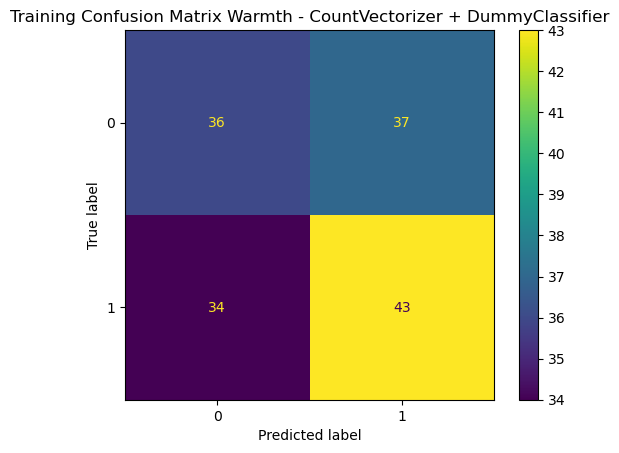

Fitting Pipeline(steps=[('CountVectorizer',
                 CountVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 3))),
                ('SelectKBest', SelectKBest(k='all')),
                ('SMOTETomek', SMOTETomek()),
                ('DummyClassifier',
                 DummyClassifier(random_state=42, strategy='stratified'))]).


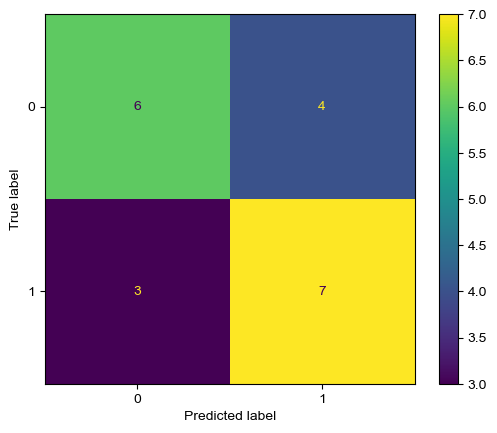

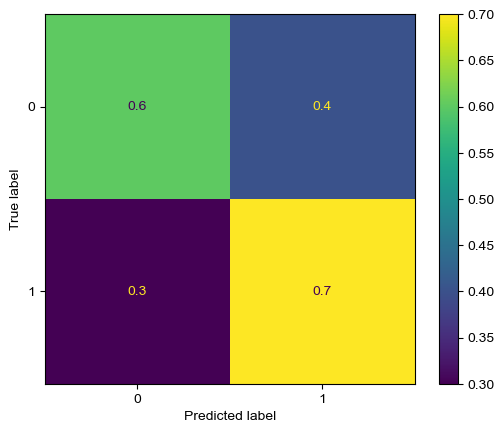

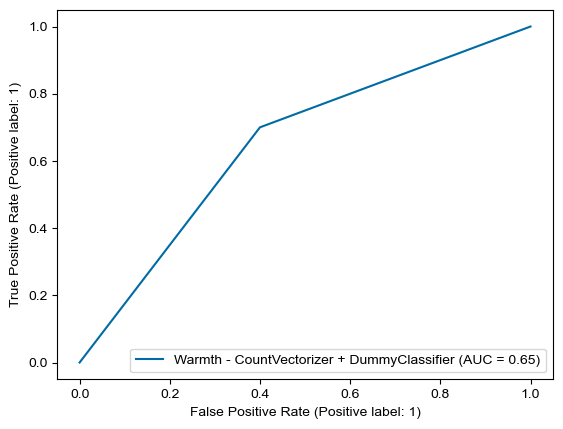

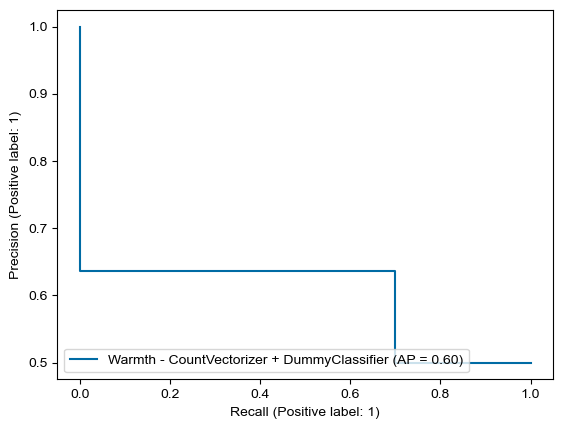

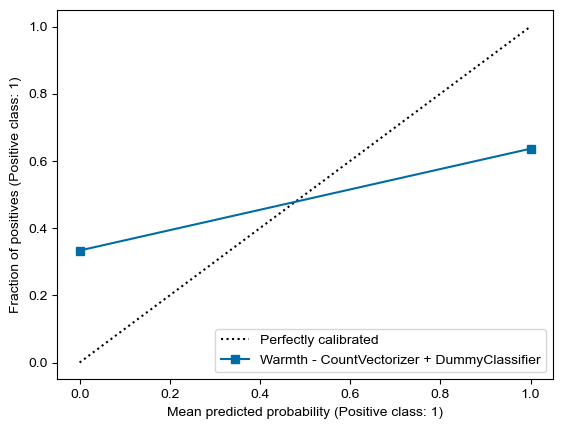

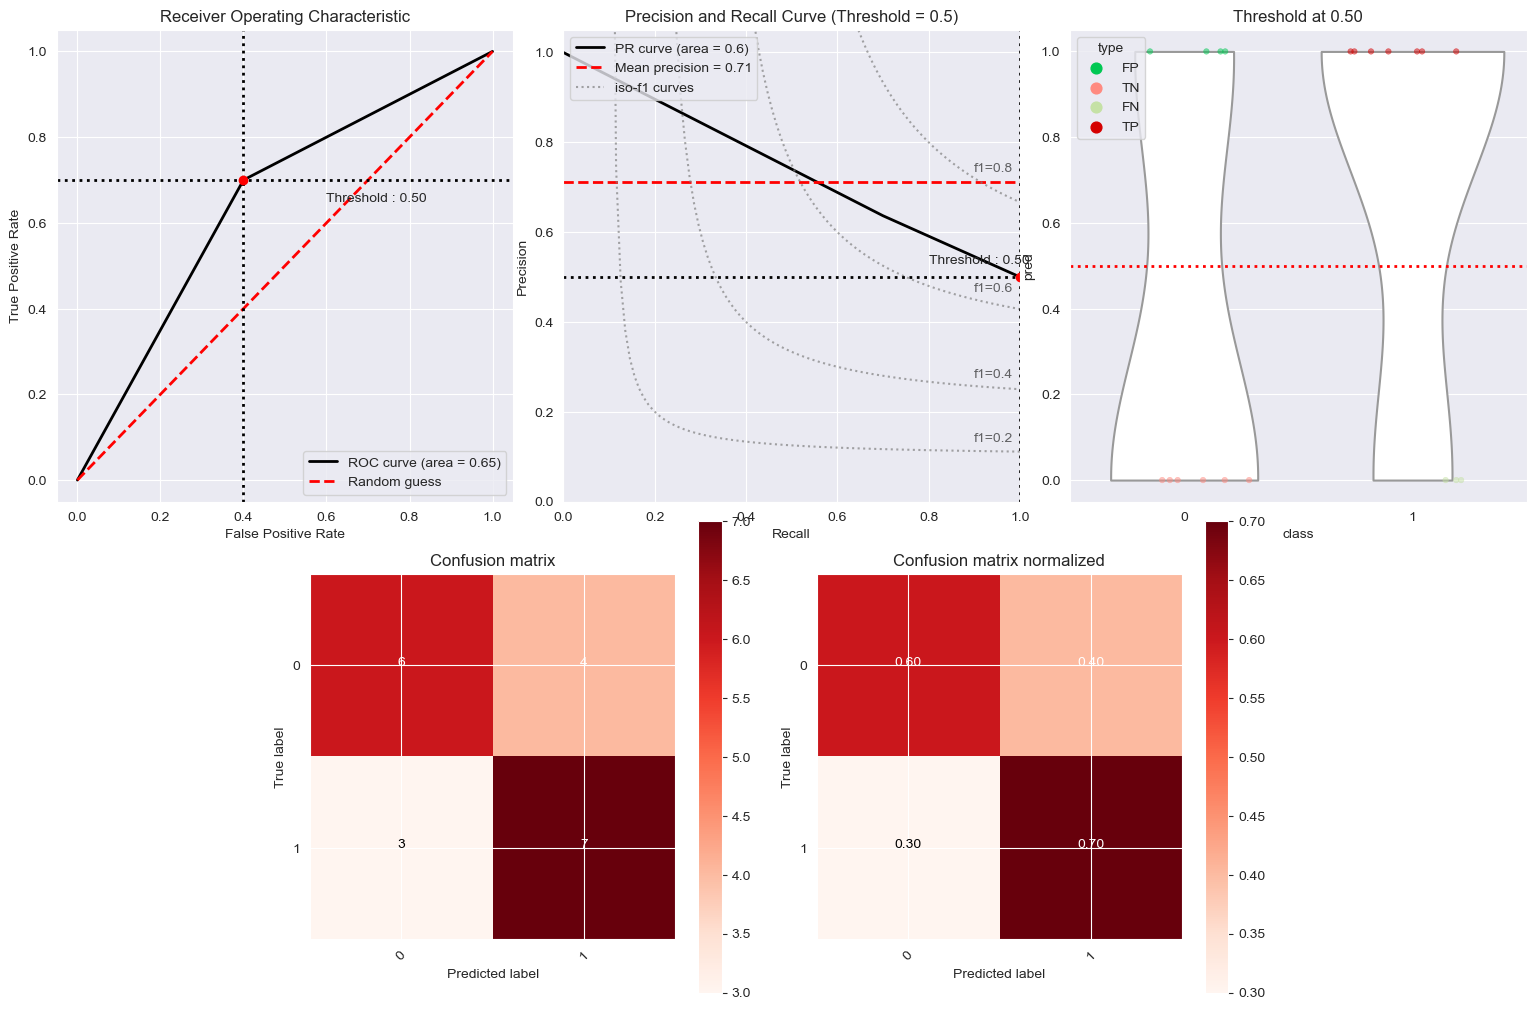

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.70      0.67        10

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20

~~~~~~~~~~~~~~~~~~~~
 Metrics for Warmth - CountVectorizer + DummyClassifier
~~~~~~~~~~~~~~~~~~~~
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.70      0.67        10

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20

--------------------
Mean Validation Score: 0.4
--------------------
Explained Variance: -1

AttributeError: 'str' object has no attribute 'round'

In [19]:
%%time
print('#'*40)
print('Starting!')
print('#'*40)

analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'

# Load Table DF
df_metrics = make_df_metrics(vectorizers_pipe, classifiers_pipe, analysis_columns, list(metrics_dict.keys()))

for col in analysis_columns:

    print('-'*20)
    print(f'{"="*30} TRAINING {col.upper()} {"="*30}')
    print('-'*20)
    print(f'Vectorizers to be used ({len(list(vectorizers_pipe.values()))}):\n{list(vectorizers_pipe.keys())}')
    print(f'Total number of vectorizer parameters = {sum([len(list(vectorizers_pipe.values())[i][1]) for i in range(len(vectorizers_pipe))])}')
    print(f'Selectors to be used ({len(list(selectors_pipe.values()))}):\n{list(selectors_pipe.keys())}')
    print(f'Total number of selector parameters = {sum([len(list(selectors_pipe.values())[i][1]) for i in range(len(selectors_pipe))])}')
    print(f'Resamplers to be used ({len(list(resamplers_pipe.keys()))}):\n{list(resamplers_pipe.keys())}')
    print(f'Total number of resamplers parameters = {sum([len(list(resamplers_pipe.values())[i][1]) for i in range(len(resamplers_pipe))])}')
    print(f'Classifers to be used ({len(list(classifiers_pipe.keys()))}):\n{list(classifiers_pipe.keys())}')
    print(f'Total number of classifers parameters = {sum([len(list(classifiers_pipe.values())[i][1]) for i in range(len(classifiers_pipe))])}')
    

    assert len(df_manual[df_manual[str(col)].map(df_manual[str(col)].value_counts() > 1)]) != 0

    # Split
    (
        train, X_train, y_train,
        test, X_test, y_test,
        val, X_val, y_val,
        class_weights,
        class_weights_ratio,
        class_weights_dict
    ) = split_data(
        df=df_manual, col=col, analysis_columns=analysis_columns, text_col=text_col
    )

    for (
        vectorizer_name, vectorizer_and_params
    ), (
        selector_name, selector_and_params
    ), (
        resampler_name, resampler_and_params
    ), (
        classifier_name, classifier_and_params
    ) in itertools.product(
        vectorizers_pipe.items(), selectors_pipe.items(), resamplers_pipe.items(), classifiers_pipe.items()
    ):

        vectorizer = vectorizer_and_params[0]
        vectorizer_params = vectorizer_and_params[1]

        selector = selector_and_params[0]
        selector_params = selector_and_params[1]

        resampler = resampler_and_params[0]
        resampler_params = resampler_and_params[1]

        classifier = classifier_and_params[0]
        classifier_params = classifier_and_params[1]

        # Pipeline
        ## Steps
        if col == 'Warmth':
            steps = [
                (vectorizer_name, vectorizer),
                (selector_name, selector),
                (resampler_name, resampler),
                (classifier_name, classifier)
            ]
        else:
            steps = [
                (vectorizer_name, vectorizer),
                (selector_name, selector),
                (classifier_name, classifier)
            ]

        ## Params
        param_grid = {
            **vectorizer_params,
            **selector_params,
            **classifier_params,
        }

        ## Pipeline
        pipe = imblearn.pipeline.Pipeline(steps=steps)

        # Search
        print('-'*20)
        print(f'{"="*30} Using GridSearchCV {"="*30}')
        print('-'*20)
        print(f'GridSearchCV with:\nPipe:\n{pipe}\nParams:\n{param_grid}')
        print('+'*30)
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            n_jobs=n_jobs,
            scoring=scores,
            cv=cv,
            refit=scores[0],
            return_train_score=True,
        )

        # Fit SearchCV
        with joblib.parallel_backend(backend='threading', n_jobs=n_jobs):
            searchcv = search.fit(X_train, y_train)

        # Best Parameters
        best_index = searchcv.best_index_
        cv_results = sorted(searchcv.cv_results_)
        mean_train_recall = searchcv.cv_results_['mean_train_recall'][best_index]
        std_train_recall = searchcv.cv_results_['std_train_recall'][best_index]
        mean_test_recall = searchcv.cv_results_['mean_test_recall'][best_index]
        std_test_recall = searchcv.cv_results_['std_test_recall'][best_index]
        best_params = searchcv.best_params_
        best_score = searchcv.best_score_
        n_splits = searchcv.n_splits_
        estimator = searchcv.best_estimator_
        y_train_pred = estimator.predict(X_train)

        # Identify and name steps in estimator
        vectorizer = estimator[0]
        vectorizer_name = vectorizer.__class__.__name__
        selector = estimator[1]
        selector_name = selector.__class__.__name__
        classifier = estimator[-1]
        classifier_name = classifier.__class__.__name__
        if col == 'Warmth':
            resampler = estimator[-2]
            resampler_name = resampler.__class__.__name__

        print('=' * 20)
        print(f'Best mean train for {scores[0].title()}: M = {mean_train_recall}, SD = {std_train_recall}')
        print(f'Best mean test for {scores[0].title()}: M = {mean_test_recall}, SD = {std_test_recall}')
        print(f'Best estimator for {scores[0].title()}: {estimator}')
        print(f'Best params for {scores[0].title()}: {best_params}')
        print(f'Best score for {scores[0].title()}: {best_score}')
        print(f'Number of splits for {scores[0].title()}: {n_splits}')
        print('-' * 20)
        print(f'GridSearchCV full results:\n{cv_results}')

        print('-' * 20)
        train_report = classification_report(y_train, y_train_pred)
        print(f'Training Classification Report:\n{train_report}')
        print(f'Training Confusion Matrix:')
        train_cm = metrics.ConfusionMatrixDisplay.from_estimator(
            estimator, X_train, y_train
        ).ax_.set_title(f'Training Confusion Matrix {str(col)} - {vectorizer_name} + {classifier_name}')
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()
        print('=' * 20)

        # Make the predictions
        if hasattr(searchcv, 'predict_proba'):
            searchcv_predict_attr = searchcv.predict_proba
        elif hasattr(searchcv, '_predict_proba_lr'):
            searchcv_predict_attr = searchcv._predict_proba_lr
        score = searchcv.score(X_test, y_test)
        y_test_pred = searchcv.predict(X_test)
        y_test_pred_prob = searchcv_predict_attr(X_test)[:, 1]

        # Fit Best Model
        print(f'Fitting {estimator}.')
        estimator.set_params(**estimator.get_params())
        estimator = estimator.fit(X_train, y_train)

        # Evaluate Model
        df_metrics, metrics_dict = evaluation(
            col, vectorizer_name, classifier_name, estimator,
            X_test, y_test, y_test_pred, y_test_pred_prob,
            best_score, scoring, df_metrics
        )

        # Save Vectorizer, Selector, and Classifier
        saving_model_and_table(df_metrics, estimator, col, vectorizer_name, classifier_name)

    # Compare Estimators
    print('='*20)
    print(f'Comparing Estimators for {col}')
    comparison_plots(get_fitted_estimators(), X_test, y_test, col)
    print('='*20)

print('#'*40)
print('DONE!')
print('#'*40)
